In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import os

In [81]:
name_params, estimate, sub, model_ID = [], [], [], []
params_save = {}
for file in os.listdir("/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/results"):
    if file.endswith(".pkl"):
        with open(f"/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/results/{file}", "rb") as f:
            params_fit = pkl.load(f)
    else:
        continue

    
    for param_category in params_fit:
        for param_key in params_fit[param_category]:
            name_params.append(param_key)
            sub.append(int(file.split("_")[0][3:]))
            model_ID.append(int(file.split("_")[1].split(".")[0][5:]))
            if type(params_fit[param_category][param_key]) == float or type(params_fit[param_category][param_key]) == int:
                estimate.append(params_fit[param_category][param_key])
            else:
                estimate.append(params_fit[param_category][param_key].default())

params_save['name'] = name_params
params_save['estimate'] = estimate
params_save['sub'] = sub
params_save['model_ID'] = model_ID
params_save = pd.DataFrame(params_save)

In [82]:
params_save = params_save.query("name != 'noise' & name != 'umixturecoef'")

In [83]:
# params = pd.read_csv("../../data/ddm_fits.csv")
behav = pd.read_csv('../../data/behavioral_data.csv')
behav = behav.query("RT > 0.2")

In [84]:
# get the condition for each unique sub
sub_cond = behav[["sub", "condition"]].drop_duplicates().reset_index(drop=True)


In [85]:
params_save = params_save.merge(sub_cond, on="sub")

<Axes: xlabel='name', ylabel='estimate'>

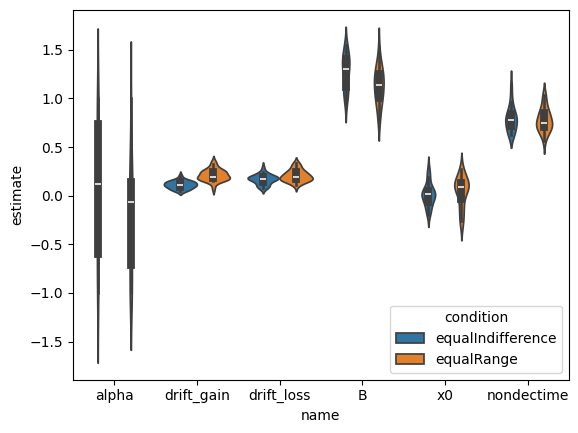

In [86]:
sns.violinplot(data=params_save, x="name", y="estimate", hue="condition")


In [87]:
import pyddm


In [95]:
params_save.query("sub == 123")


,name,estimate,sub,model_ID,condition
54,alpha,0.274023,123,1,equalIndifference
55,drift_gain,0.065289,123,1,equalIndifference
56,drift_loss,0.088144,123,1,equalIndifference
57,B,1.245993,123,1,equalIndifference
58,x0,-0.067736,123,1,equalIndifference
59,nondectime,0.779243,123,1,equalIndifference


In [109]:
sub = 3
x0 = params_save.query(f"sub == {sub} & name == 'x0'")['estimate'].values[0]
alpha = params_save.query(f"sub == {sub} & name == 'alpha'")['estimate'].values[0]
drift_gain = params_save.query(f"sub == {sub} & name == 'drift_gain'")['estimate'].values[0]
drift_loss = params_save.query(f"sub == {sub} & name == 'drift_loss'")['estimate'].values[0]
nondecision = params_save.query(f"sub == {sub} & name == 'nondectime'")['estimate'].values[0]
bound = params_save.query(f"sub == {sub} & name == 'B'")['estimate'].values[0]

model = pyddm.gddm(starting_position=x0,
            drift=lambda gain, loss: alpha + drift_gain * gain - drift_loss * loss,
            nondecision=nondecision,
            bound=bound,
            conditions=['gain', 'loss'],
            T_dur=4,
            dx=0.002,
            dt=0.002)


In [115]:
a = 2.28
x0 = 0.49
nondec = 0.51
theta = 0.61
alpha = 0.18
drift_gain = 0.06
drift_loss = -0.08

model2 = pyddm.gddm(starting_position=x0,
            drift=lambda gain, loss: alpha + drift_gain * gain - drift_loss * loss,
            nondecision=nondec,
            bound=lambda t: a - theta * t,
            conditions=['gain', 'loss'],
            T_dur=4,
            dx=0.002,
            dt=0.002)

In [116]:
def get_model_samples(sub, ddm_model, samples_per_condition = 200):
    df_model = {"gain" : [], "loss" : [], "rt": [], "accept" : []}

    for indx, row in sub.iterrows():
        sample = ddm_model.solve(conditions={"gain" : row['gain'], "loss": row['loss']}).sample(samples_per_condition)
        for s in sample.choice_upper:
            df_model["gain"].append(row['gain'])
            df_model["loss"].append(row['loss'])
            df_model["rt"].append(s)
            df_model["accept"].append(1)
        for s in sample.choice_lower:
            df_model["gain"].append(row['gain'])
            df_model["loss"].append(row['loss'])
            df_model["rt"].append(s)
            df_model["accept"].append(0)

    return df_model

In [117]:
behav_sub3 = behav.query("sub == 3")
x = get_model_samples(behav_sub3, model, samples_per_condition=50)
x2 = get_model_samples(behav_sub3, model2, samples_per_condition=50)
x = pd.DataFrame(x)
x2 = pd.DataFrame(x2)

In [118]:
# make the rt for accept 0 be negative
x.loc[x['accept'] == 0, 'rt'] = -x.loc[x['accept'] == 0, 'rt']
x2.loc[x2['accept'] == 0, 'rt'] = -x2.loc[x2['accept'] == 0, 'rt']
#do same for behav_sub3
behav_sub3.loc[behav_sub3['accept'] == 0, 'RT'] = -behav_sub3.loc[behav_sub3['accept'] == 0, 'RT']

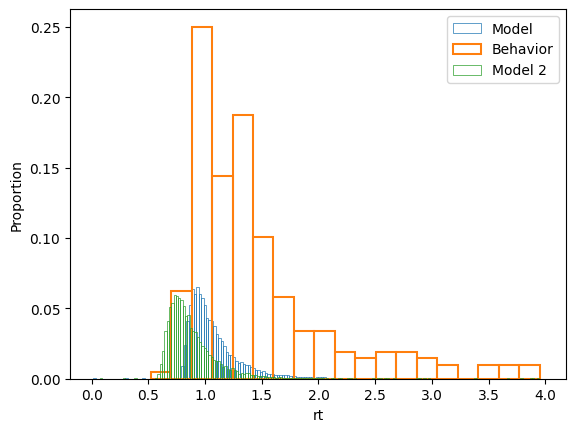

In [119]:
sns.histplot(data=x.query("accept == 1"), x='rt', multiple='stack', fill=False, stat='proportion', label='Model')
sns.histplot(data=behav_sub3.query("accept == 1"), x='RT', multiple='stack', fill=False, stat='proportion', label='Behavior')
sns.histplot(data=x2.query("accept == 1"), x='rt', multiple='stack', fill=False, stat='proportion', label='Model 2')
plt.legend()
plt.show()


In [63]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.kdeplot(data=x.query('condition == "equalIndifference" & accept == 1'), x='RT', fill=True, color='green', label='Accept', ax=axs[0])
sns.kdeplot(data=x.query('condition == "equalIndifference" & accept == 0'), x='RT', fill=True, color='red', label='Reject', ax=axs[0])
sns.kdeplot(data=x.query('condition == "equalRange" & accept == 1'), x='RT', fill=True, color='green', label='Accept', ax=axs[1]) 
sns.kdeplot(data=x.query('condition == "equalRange" & accept == 0'), x='RT', fill=True, color='red', label='Reject', ax=axs[1])
axs[0].set_title('High Reward Condition')
axs[1].set_title('Low Reward Condition')
axs[0].legend()
axs[1].legend()
plt.show()

,Unnamed: 0,sub,run,condition,gain,loss,RT,accept,response_int,participant_response,trial,uncertain,dist_from_indiff
0,512,3,1,equalIndifference,14,14,1.247,1,4.0,strongly_accept,1,0,0.000000
1,513,3,1,equalIndifference,38,14,1.041,1,4.0,strongly_accept,2,0,16.970563
2,514,3,1,equalIndifference,10,18,2.803,1,3.0,weakly_accept,3,1,5.656854
3,515,3,1,equalIndifference,16,5,0.936,1,4.0,strongly_accept,4,0,7.778175
4,516,3,1,equalIndifference,40,12,1.142,1,4.0,strongly_accept,5,0,19.798990
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,763,3,4,equalIndifference,26,6,2.392,1,4.0,strongly_accept,252,0,14.142136
252,764,3,4,equalIndifference,26,15,1.038,1,4.0,strongly_accept,253,0,7.778175
253,765,3,4,equalIndifference,24,5,1.869,1,4.0,strongly_accept,254,0,13.435029
254,766,3,4,equalIndifference,32,10,1.144,1,4.0,strongly_accept,255,0,15.556349


In [62]:
x = pd.DataFrame(x)

In [5]:
params["pt"] = params["drift_loss"] / params["drift_gain"]

In [6]:
params

,sub,alpha,drift_gain,drift_loss,bound,response_bias,nondecision,BIC,condition,pt
0,3,-0.448214,0.092914,0.076424,1.218000,0.275578,0.740665,214.382369,equalIndifference,0.822526
1,5,0.500000,0.102338,0.236166,0.964017,0.170950,0.869672,186.807571,equalIndifference,2.307700
2,6,0.190184,0.257670,0.301858,0.903779,0.072516,0.742296,89.056929,equalRange,1.171491
3,9,-0.324886,0.137984,0.178142,1.413445,-0.011451,0.832158,203.052992,equalIndifference,1.291037
4,10,0.138671,0.177424,0.183390,1.450296,0.129642,0.920511,306.714425,equalRange,1.033625
5,11,0.500000,0.136173,0.157565,1.208000,0.051922,0.643623,76.396267,equalIndifference,1.157099
6,14,-0.071311,0.346890,0.332347,1.045658,-0.007027,0.722837,88.219056,equalRange,0.958076
7,19,-0.500000,0.145445,0.189270,1.297359,0.014277,0.716521,195.366406,equalIndifference,1.301320
8,20,-0.063585,0.164307,0.155145,1.222187,0.085362,1.019260,300.148436,equalRange,0.944235
9,22,-0.012818,0.083588,0.170012,0.982091,-0.145485,0.856843,165.050453,equalRange,2.033929


<Axes: xlabel='condition', ylabel='pt'>

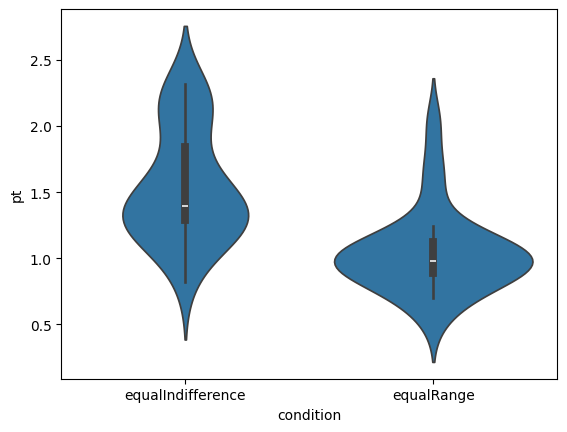

In [7]:
sns.violinplot(data=params, x="condition", y="pt")

<Axes: xlabel='condition', ylabel='alpha'>

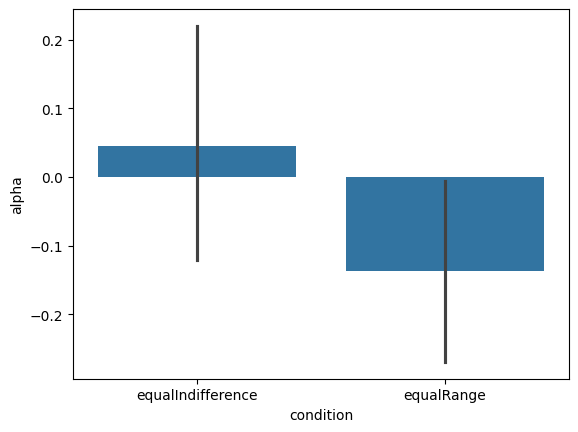

In [8]:
# violin plot of alpha by condition
sns.barplot(data=params, x="condition", y="alpha")

<Axes: xlabel='condition', ylabel='drift_gain'>

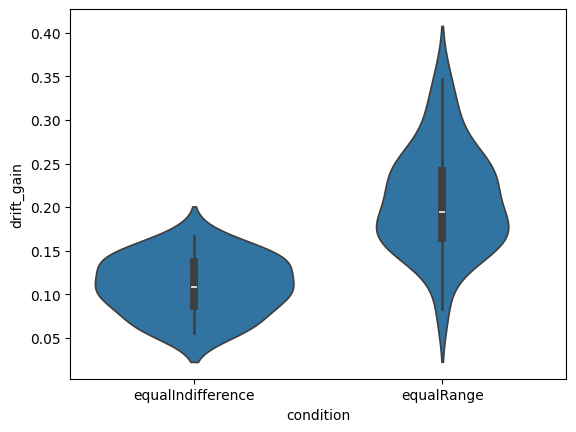

In [16]:
# violin plot of drift_gain by condition
sns.violinplot(data=params, x="condition", y="drift_gain")

<Axes: xlabel='condition', ylabel='drift_loss'>

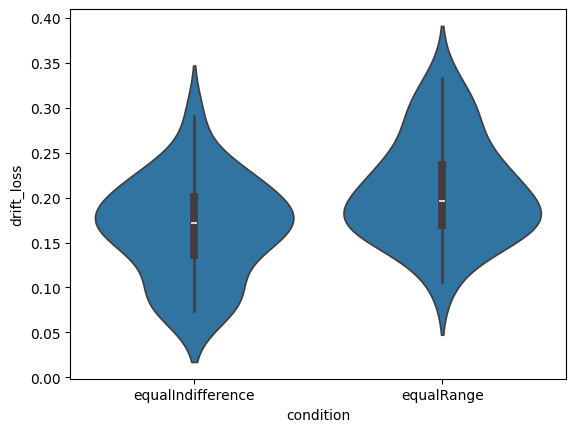

In [19]:
# violin plot of drift_loss by condition
sns.violinplot(data=params, x="condition", y="drift_loss")

<Axes: xlabel='condition', ylabel='pt'>

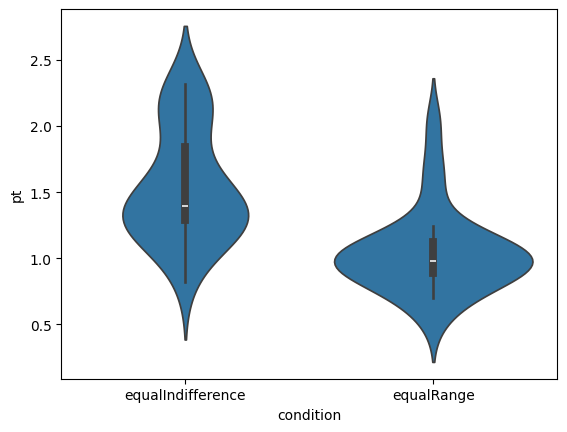

In [20]:
# violin plot of pt by condition
sns.violinplot(data=params, x="condition", y="pt")

<Axes: xlabel='condition', ylabel='nondecision'>

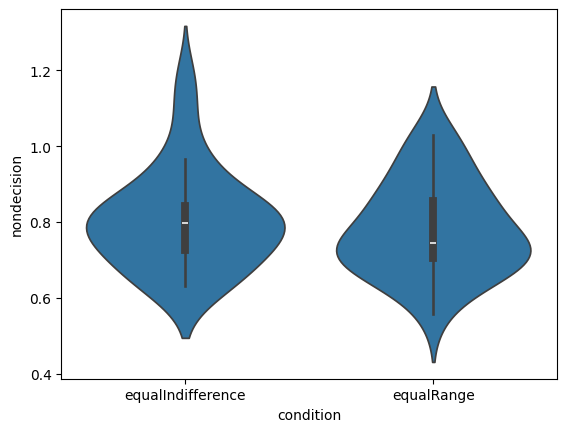

In [22]:
# violin plot of pt by condition
sns.violinplot(data=params, x="condition", y="nondecision")

<Axes: xlabel='condition', ylabel='response_bias'>

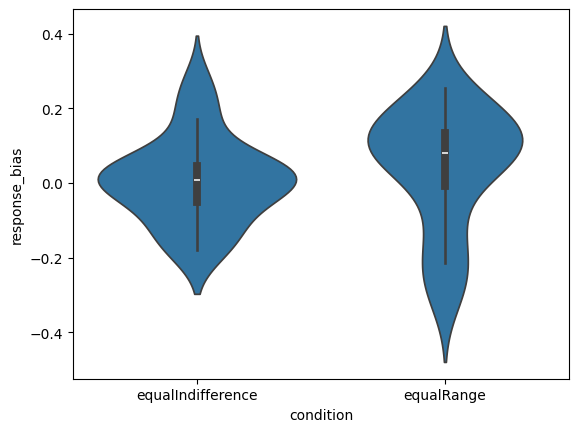

In [24]:
# violin of response_bias by condition
sns.violinplot(data=params, x="condition", y="response_bias")


##### Extracting pupil response bin before decision is made
We wish to determine how pupil response is linked to the decision process. For this, we need to extract an integer describing how pupil is changing before a decision has been made. For each subject, we extract:
1. Baseline pupil bin from 0.5 sec before start of trial until start of trial
    - Tonic
2. Mean derivative of pupil (how fast it grow) from start of trial until decision
    - Phasic

In [2]:
# Import and process data
pupil_df = pd.read_csv("./data/behavior_pupil.csv")
# Remove trials that are the start of a run, have no response, or have a reaction time less than 0.1
pupil_df = pupil_df.query("is_start_of_run != 1 & response_int.notna() & rt > 0.1")
# Rename columns
pupil_df.rename(columns={"value" : "pupil_size"}, inplace=True)
# create new column called Uncertainty where it is 0 if response_int is 1 or 4 and 1 if response_int is 2 or 3
pupil_df.loc[:, "uncertainty"] = np.where(pupil_df["response_int"].isin([1, 4]), 0, 1)
# create a new column called condition_num where it is 0 if condition is equalRange and 1 if condition is equalIndifference
pupil_df.loc[:, "condition_num"] = np.where(pupil_df["condition"] == "equalRange", 0, 1)

In [3]:
# add first derivative of pupil size
sr = 50
pupil_df.loc[:, "pupil_size_deriv"] = pupil_df.groupby(["subj_ID", "trial"])["pupil_size"].diff() * sr
pupil_df.loc[:, "pupil_size_deriv"] = pupil_df["pupil_size_deriv"].fillna(0)

In [31]:
def compute_avg_pupil_size(group):
    filtered = group[(group["time"] > 0) & (group["time"] < group["rt"].iloc[0])]
    group["mean_deriv"] = filtered["pupil_size_deriv"].mean()
    return group

In [11]:
baseline = pupil_df.query("time < 0").groupby(["subj_ID", "gain", "loss", "trial", "accept", "rt"])[["pupil_size"]].mean().reset_index()
deriv = pupil_df.groupby(["subj_ID", "trial", "gain", "loss", "accept", "rt"], group_keys=False).apply(compute_avg_pupil_size)
deriv = deriv[["subj_ID", "gain", "loss", "trial", "mean_deriv", "accept", "rt"]].drop_duplicates()

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_29562/3664555310.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  deriv = pupil_df.groupby(["subj_ID", "trial", "gain", "loss", "accept", "rt"], group_keys=False).apply(compute_avg_pupil_size)


In [6]:
def bin_pupil_sizes(group, bin_num):
    group["baseline_bin"] = pd.qcut(group["pupil_size"], q=bin_num, labels=range(bin_num))
    return group

def bin_deriv(group, bin_num):
    group["deriv_bin"] = pd.qcut(group["mean_deriv"], q=bin_num, labels=range(bin_num))
    return group

In [19]:
# Apply binning by subject
baseline = baseline.groupby("subj_ID", group_keys=False).apply(bin_pupil_sizes, bin_num=2)
deriv = deriv.groupby("subj_ID", group_keys=False).apply(bin_deriv, bin_num=2)

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_29562/3997902258.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  baseline = baseline.groupby("subj_ID", group_keys=False).apply(bin_pupil_sizes, bin_num=2)
/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_29562/3997902258.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  deriv = deriv.groupby("subj_ID", group_keys=False).apply(bin_de

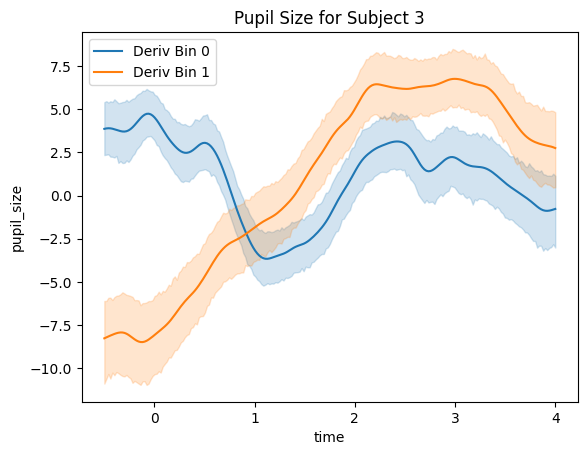

In [8]:
# give me list of trials with deriv_bin 0 for subj_ID 3
deriv_bin_0 = deriv.query("subj_ID == 3 & deriv_bin == 0")["trial"].unique()
# give me list of trials with deriv_bin 1 for subj_ID 3
deriv_bin_1 = deriv.query("subj_ID == 3 & deriv_bin == 1")["trial"].unique()

# plot pupil size for trials with deriv_bin 0 and 1 for subj_ID 3
plt.figure()
sns.lineplot(data=pupil_df.query("subj_ID == 3 & trial in @deriv_bin_0"), x="time", y="pupil_size", label="Deriv Bin 0")
sns.lineplot(data=pupil_df.query("subj_ID == 3 & trial in @deriv_bin_1"), x="time", y="pupil_size", label="Deriv Bin 1")

plt.title("Pupil Size for Subject 3")
plt.show()

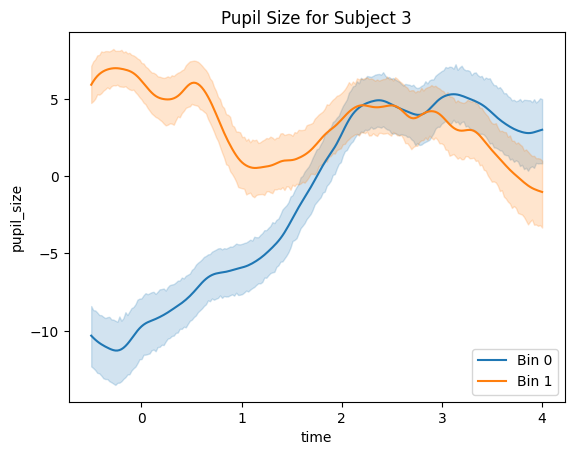

In [9]:
# give me list of trials with deriv_bin 0 for subj_ID 3
baseline_bin_0 = baseline.query("subj_ID == 3 & baseline_bin == 0")["trial"].unique()
# give me list of trials with deriv_bin 1 for subj_ID 3
baseline_bin_1 = baseline.query("subj_ID == 3 & baseline_bin == 1")["trial"].unique()

# plot pupil size for trials with deriv_bin 0 and 1 for subj_ID 3
plt.figure()
sns.lineplot(data=pupil_df.query("subj_ID == 3 & trial in @baseline_bin_0"), x="time", y="pupil_size", label="Bin 0")
sns.lineplot(data=pupil_df.query("subj_ID == 3 & trial in @baseline_bin_1"), x="time", y="pupil_size", label="Bin 1")

plt.title("Pupil Size for Subject 3")
plt.show()

In [28]:
# save new df with subj_ID, rt, accept, gain, loss, deriv_bin, baseline_bin
new_df = deriv.merge(baseline, on=["subj_ID", "trial", "gain", "loss", "accept", "rt"])
new_df = new_df[["subj_ID", "rt", "accept", "gain", "loss", "deriv_bin", "baseline_bin"]]

In [30]:
# save 
new_df.to_csv("./data/behavior_pupil_binned.csv", index=False)